## CNN USING EEG DATA WITH NO_COH feature ##

In this notebook you will be able to see custom CNN model for EEG Data. Data consists of the 19 electrodes with signals of 6 frequency bands -- delta, theta, alpha, beta, highbeta and gamma.

In [1]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import numpy as np

#importing final dataset prepared for training after ETA and EDA to prepare a CNN based classification model.

df = pd.read_csv('./data/final_dataset_all_no_coh_train.csv')
df.head()

,delta.FP1,delta.FP2,delta.F7,delta.F3,delta.Fz,delta.F4,delta.F8,delta.T3,delta.C3,delta.Cz,...,gamma.C4,gamma.T4,gamma.T5,gamma.P3,gamma.Pz,gamma.P4,gamma.T6,gamma.O1,gamma.O2,main.disorder
0,13.425118,11.002916,11.942516,15.272216,14.151570,12.456034,8.436832,9.975238,14.834740,10.950564,...,0.931967,0.437117,0.930843,1.234874,1.373268,1.411808,1.140695,1.118041,3.162143,Addictive disorder
1,29.941780,27.544684,17.150159,23.608960,27.087811,13.541237,16.523963,12.775574,21.686306,18.367666,...,1.691152,1.505663,1.133891,1.661768,1.403429,1.349457,1.270525,1.408471,1.454618,Addictive disorder
2,21.496226,21.846832,17.364316,13.833701,14.100954,13.100939,14.613650,8.063191,11.015078,11.639560,...,1.122776,2.128138,1.648217,1.147666,1.049152,1.131654,1.415856,1.391048,1.527403,Addictive disorder
3,37.775667,33.607679,21.865556,21.771413,22.854536,21.456377,15.969042,9.434306,15.244523,17.041979,...,2.320845,3.562820,1.441662,1.018804,1.274009,2.350806,2.307730,2.129431,3.766860,Addictive disorder
4,13.482096,14.095855,12.854630,11.727480,13.128924,11.627138,14.978119,6.899770,9.751346,14.141171,...,2.780522,5.419482,2.587215,1.694676,1.748525,1.527331,1.664579,1.266546,1.133410,Addictive disorder


- We have total of 115 columns in this dataset including our target `main.disorder`
- Thus we will use 114 features to predict the main-disorder of a person

## Preparing Train-Valid Data
- Since we already have prepared the train and test data ahead to prevent the data leakage, now we will separate the train data into train-valid data.
#### ONE HOT ENCODING FOR TARGETS ####
- Since we have seven classes including healthy control we encoded the `target - main.disorder` with the one hot encoding.
- This makes our y_data into shape of nx7

In [2]:
target = 'main.disorder'

y = df[target].copy()
y.shape

(1792,)

In [3]:
Y = pd.get_dummies(y)
Y.shape

(1792, 7)

In [4]:
Y.head()

,Addictive disorder,Anxiety disorder,Healthy control,Mood disorder,Obsessive compulsive disorder,Schizophrenia,Trauma and stress related disorder
0,1,0,0,0,0,0,0
1,1,0,0,0,0,0,0
2,1,0,0,0,0,0,0
3,1,0,0,0,0,0,0
4,1,0,0,0,0,0,0


In [5]:
X = df.drop([target], axis = 1)
X.shape

(1792, 114)

In [6]:
from sklearn.model_selection import train_test_split
def train_test_dataset(X,y, split):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=split, random_state=42)
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = train_test_dataset(X,Y, split = 0.10)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1612, 114), (180, 114), (1612, 7), (180, 7))

### This is the shape of our final train and valid data ###

- Below this cell we tried to make sure that all the classes are included in our train and valid dataset

In [7]:
# Make sure that in 10% split we will have all the classes in valid and train set.

assert len(y_test.sum(axis=0)) == len(y_train.sum(axis=0))
y_test.sum(axis=0), y_train.sum(axis=0)

(Addictive disorder                    25
 Anxiety disorder                      23
 Healthy control                       19
 Mood disorder                         34
 Obsessive compulsive disorder         28
 Schizophrenia                         26
 Trauma and stress related disorder    25
 dtype: int64,
 Addictive disorder                    231
 Anxiety disorder                      233
 Healthy control                       237
 Mood disorder                         222
 Obsessive compulsive disorder         228
 Schizophrenia                         230
 Trauma and stress related disorder    231
 dtype: int64)

## USING MINMAX NORMALIZATION FOR THE SIGNAL DATA ##

$$ m = \frac{(x -xmin)}{(xmax -xmin)} $$

In [8]:
#using sklearn for preprocessing
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train),columns=X.columns)
X_test = pd.DataFrame(scaler.transform(X_test),columns=X.columns)

### Prepare custom dataset to load the data in dataloader for pytorch approarch ###

In [9]:
#Prepare manual dataset that will return target and features to our model
torch.manual_seed(555)
datasets = {}
class EEGDataset(Dataset):
    def __init__(self, X,y):
        self.X = torch.tensor(X.values)
        self.y = torch.tensor(y.values)

    def __getitem__(self, idx):
        preds = self.X[idx].float()
        trgts = self.y[idx].float()
        
        return preds, trgts

    def __len__(self):
        return len(self.X)

datasets['train'] = EEGDataset(X_train,y_train)
datasets['test'] = EEGDataset(X_test,y_test)

In [10]:
datasets['train'][0], datasets['test'][0]

((tensor([0.2259, 0.2559, 0.3242, 0.2796, 0.2551, 0.3591, 0.3107, 0.2226, 0.3444,
          0.2512, 0.3456, 0.3165, 0.2525, 0.3528, 0.1686, 0.3214, 0.2196, 0.1538,
          0.2067, 0.0593, 0.0652, 0.0744, 0.0737, 0.0763, 0.0793, 0.0755, 0.0481,
          0.0780, 0.0886, 0.0877, 0.0850, 0.0527, 0.0687, 0.0489, 0.0816, 0.0692,
          0.0253, 0.0578, 0.0351, 0.0393, 0.0354, 0.0245, 0.0334, 0.0253, 0.0304,
          0.0214, 0.0178, 0.0182, 0.0206, 0.0367, 0.0161, 0.0120, 0.0101, 0.0198,
          0.0206, 0.0105, 0.0118, 0.4080, 0.4028, 0.3024, 0.3488, 0.4091, 0.3877,
          0.3765, 0.1671, 0.2988, 0.1999, 0.2712, 0.2659, 0.2227, 0.1950, 0.1236,
          0.1670, 0.1831, 0.1019, 0.1107, 0.6589, 0.4787, 0.4889, 0.4419, 0.6868,
          0.7083, 0.4872, 0.2284, 0.4569, 0.9553, 0.3211, 0.4261, 0.2748, 0.8509,
          0.7703, 0.9092, 0.5262, 0.1656, 0.1422, 0.4260, 0.3564, 0.2897, 0.2461,
          0.5579, 0.5248, 0.2326, 0.1029, 0.2230, 0.4399, 0.1366, 0.1991, 0.1287,
          0.3608

In [11]:
#Add data to train and test loader
#We didnt use the batch size since we have few data that our memory can handle
#Try using batch size if your dataset is very huge

train_loader = DataLoader(datasets['train'], shuffle=True)
test_loader = DataLoader(datasets['test'],shuffle=True)

In [12]:
#Check data in dataloader
for X, y in train_loader:
    print(X)
    print(y)
    break

tensor([[0.0635, 0.0981, 0.0942, 0.0907, 0.0818, 0.0959, 0.1697, 0.0883, 0.1827,
         0.1233, 0.2363, 0.1146, 0.1480, 0.1516, 0.2569, 0.1523, 0.0561, 0.3166,
         0.1016, 0.0353, 0.0424, 0.0374, 0.0448, 0.0458, 0.0409, 0.0461, 0.0288,
         0.0605, 0.0650, 0.0658, 0.0289, 0.0316, 0.0532, 0.1054, 0.0611, 0.0197,
         0.0402, 0.0352, 0.1324, 0.1288, 0.1134, 0.0957, 0.1202, 0.0889, 0.0922,
         0.0730, 0.0881, 0.0928, 0.0756, 0.0611, 0.0500, 0.0677, 0.0950, 0.0920,
         0.0487, 0.1237, 0.0886, 0.2250, 0.1950, 0.1358, 0.1672, 0.1937, 0.1719,
         0.1872, 0.1408, 0.2247, 0.1472, 0.1928, 0.1068, 0.2156, 0.2298, 0.2341,
         0.1637, 0.0997, 0.2369, 0.1413, 0.0794, 0.0537, 0.0559, 0.0439, 0.0659,
         0.0635, 0.0577, 0.0537, 0.0586, 0.1111, 0.0403, 0.0488, 0.0536, 0.1407,
         0.1877, 0.1409, 0.0540, 0.0470, 0.0250, 0.0450, 0.0334, 0.0264, 0.0198,
         0.0404, 0.0400, 0.0254, 0.0206, 0.0265, 0.0469, 0.0160, 0.0220, 0.0219,
         0.0523, 0.0587, 0.0

In [13]:
print("Number of training samples: ",len(datasets['train']))
print("Number of testing samples: ",len(datasets['test']))

Number of training samples:  1612
Number of testing samples:  180


In [14]:
#function to find the parameters of the network
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')

In [15]:
#Small Network with fewer hidden layers
class eegConv1d(nn.Module):
    def __init__(self, input_size = 1, hidden_size=32, out_size=7):
        super().__init__()
        self.conv1d   = nn.Conv1d(input_size, hidden_size, kernel_size = 3,stride =1)
        # nn.init.normal_(self.conv1d.weight, mean=0.0, std=1)  #Use this if you want to initialize your weight with normal distribution
        self.linear = nn.Linear(3584, out_size) 
        
    def forward(self, seq):
        #seq = seq.unsqueeze(dim=0)
        out = self.conv1d(seq) 
        out = out.reshape(-1,3584)
        out = self.linear(out)
        return out  

In [16]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(1,64,6,stride = 1)
        # nn.init.normal_(self.conv1.weight, mean=0.0, std=1)
        self.conv2 = nn.Conv1d(64,8,6,stride = 1)
        # nn.init.normal_(self.conv2.weight, mean=0.0, std=1)
        self.linear1 = nn.Linear(832,128) 
        self.linear2 = nn.Linear(128, 7)
        self.leakyrelu = nn.LeakyReLU()
        self.dropout = nn.Dropout(p = 0.25)
    def forward(self, X):
        #X = X.unsqueeze(dim=0)  #Use this if you have dimension problem
        X = self.leakyrelu(self.conv1(X))
        X = self.leakyrelu(self.conv2(X)) 
#         X = self.dropout(X) #Use dropout if you have to decrease the no. of hidden sizes in hidden layer
#         X = self.dropout(X)
        X = X.view(-1, 832)
        X = self.leakyrelu(self.linear1(X))
        X = self.dropout(X)
        X = self.leakyrelu(self.linear2(X))

        return X

In [17]:
#Send model to device- Use cuda if available for high computation power

device = torch.device('cuda:2')
CNNmodel_s  = eegConv1d().to(device)
print("Small Model parameters")
count_parameters(CNNmodel_s)

Small Model parameters
    96
    32
 25088
     7
______
 25223


In [18]:
#Send model to device- Use cuda if available for high computation power

CNNmodel_l  = CNN().to(device)
print("Large Model parameters")
count_parameters(CNNmodel_l)

Large Model parameters
   384
    64
  3072
     8
106496
   128
   896
     7
______
111055


## SELECT FROM THE ABOVE MODELs FOR TRAINING ##

In [19]:
print("Please select from above models... 0 for simple model, 1 for deep model")
mod = int(input())
if mod == 0:
    CNNmodel = CNNmodel_s
    mo = "Simple"
elif mod == 1:
    CNNmodel = CNNmodel_l
    mo = "Deep"

Please select from above models... 0 for simple model, 1 for deep model


 1


In [20]:
# Model you selected
CNNmodel

CNN(
  (conv1): Conv1d(1, 64, kernel_size=(6,), stride=(1,))
  (conv2): Conv1d(64, 8, kernel_size=(6,), stride=(1,))
  (linear1): Linear(in_features=832, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=7, bias=True)
  (leakyrelu): LeakyReLU(negative_slope=0.01)
  (dropout): Dropout(p=0.25, inplace=False)
)

### SELECT OPTIMIZER, LEARNING RATES AND OTHER HYPERPARAMS FOR TRAINING ###

In [21]:
criterion = nn.CrossEntropyLoss()
print("Choose optimizer. Enter 0 for Adam and 1 for SGD")
op = input()
if int(op) == 0:
    optim = 'ADAM'
    print("Enter the learning rate")
    learning_rate = float(input())
    optimizer = torch.optim.Adam(CNNmodel.parameters(), lr=learning_rate)
    
elif int(op) == 1:
    optim = 'SGD'
    print("Enter the learning rate")
    learning_rate = float(input())
    print("Enter the momentum value.. (0-1)")
    m = float(input())
    optimizer = torch.optim.SGD(CNNmodel.parameters(), lr=learning_rate, momentum = m)

Choose optimizer. Enter 0 for Adam and 1 for SGD


 0


Enter the learning rate


 0.00032


In [22]:
optimizer, criterion

(Adam (
 Parameter Group 0
     amsgrad: False
     betas: (0.9, 0.999)
     capturable: False
     differentiable: False
     eps: 1e-08
     foreach: None
     fused: False
     lr: 0.00032
     maximize: False
     weight_decay: 0
 ),
 CrossEntropyLoss())

In [23]:
CNNmodel

CNN(
  (conv1): Conv1d(1, 64, kernel_size=(6,), stride=(1,))
  (conv2): Conv1d(64, 8, kernel_size=(6,), stride=(1,))
  (linear1): Linear(in_features=832, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=7, bias=True)
  (leakyrelu): LeakyReLU(negative_slope=0.01)
  (dropout): Dropout(p=0.25, inplace=False)
)

## TRAINING AND VALIDATION ##

In [24]:
import time

epochs = 100

train_losses = []
val_losses = []
train_accuracy = []
val_accuracy = []
best_val_loss = 10
early_stoping = False
j=0


for i in range(epochs):
    start_time = time.time()
    confusion_matrix = np.zeros((7,7))
    train_correct = 0
    train_total = 0
    val_total   = 0  
    train_acc   = 0
    val_acc     = 0
    val_correct = 0
    CNNmodel.train()
    for X_train, y_train in train_loader:
        y_train = y_train.to(device)
        X_train = X_train.to(device)
        y_pred = CNNmodel(X_train)
        predicted = torch.max(y_pred, 1)[1]
        train_total += y_train.size(0)
        train_correct += (predicted == torch.argmax(y_train,1)).sum().item()
        train_acc = 100 * (train_correct / train_total)
        train_loss = criterion(y_pred, y_train)
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
    train_losses.append(train_loss)
    train_accuracy.append(train_acc)
    
    # Run the validation batches
    with torch.no_grad():
        for b, (X_val, y_val) in enumerate(test_loader):
            y_val = y_val.to(device)
            X_val = X_val.to(device)
            yhat_val = CNNmodel(X_val)     
            _, predicted = torch.max(yhat_val.data, 1)
            val_total += y_val.size(0)  #keep track of total
            actual = torch.argmax(y_val,1)
            val_correct += (predicted == actual).sum().item()  #.item() give the raw number
            confusion_matrix[predicted][actual] +=1
            val_acc = 100 * (val_correct / val_total)
            val_loss = criterion(yhat_val, y_val)
    val_losses.append(val_loss)
    val_accuracy.append(val_acc)
    end_time = time.time()
    print(f"Epoch {i} train_loss:{train_loss:10.3f} train_acc:{train_acc:10.4f} val_acc: {val_acc:10.3f} val_loss:{val_loss:10.4f}")
     
    if val_loss > best_val_loss:
        j = j+1
        if j==10:
            print(f".................Early stoping....................at Epoch :{i+1}" )
            print(confusion_matrix)
            break
    elif best_val_loss>val_loss:
        j = 0
        best_val_loss = val_loss
        xyz = 'models/no_COH_epoch_' + str(i) + '_model_' + str(mo) +'_' +str(optim) + '.pth.tar'
        torch.save(CNNmodel.state_dict(), xyz)

Epoch 0 train_loss:     1.954 train_acc:   15.9429 val_acc:     11.667 val_loss:    1.9525
Epoch 1 train_loss:     1.982 train_acc:   18.3002 val_acc:     14.444 val_loss:    1.9790
Epoch 2 train_loss:     1.944 train_acc:   19.8511 val_acc:     15.000 val_loss:    1.9413
Epoch 3 train_loss:     1.994 train_acc:   19.2308 val_acc:     20.000 val_loss:    2.0354
Epoch 4 train_loss:     1.987 train_acc:   24.4417 val_acc:     21.111 val_loss:    2.2717
Epoch 5 train_loss:     2.224 train_acc:   25.6824 val_acc:     23.333 val_loss:    2.3038
Epoch 6 train_loss:     1.750 train_acc:   28.7221 val_acc:     31.667 val_loss:    1.8945
Epoch 7 train_loss:     2.370 train_acc:   31.2655 val_acc:     30.556 val_loss:    1.9461
Epoch 8 train_loss:     1.154 train_acc:   35.8561 val_acc:     28.333 val_loss:    0.7884
Epoch 9 train_loss:     1.331 train_acc:   41.5012 val_acc:     35.556 val_loss:    3.3725
Epoch 10 train_loss:     1.044 train_acc:   44.0447 val_acc:     40.000 val_loss:    1.666

In [25]:
val_losses[0].item()

1.9524716138839722

In [26]:
train_losses = [tensor.item() for tensor in train_losses]
val_losses = [tensor.item() for tensor in val_losses]

### VALIDATION AND TRAINING LOSS COMPARISION ###

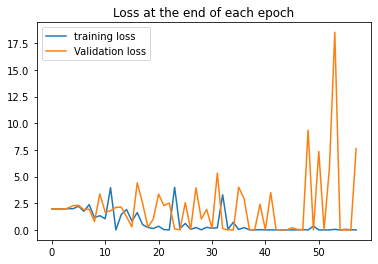

In [27]:
import matplotlib.pyplot as plt
plt.plot(train_losses, label='training loss')
plt.plot(val_losses, label='Validation loss')
plt.title('Loss at the end of each epoch')
plt.legend();
# plt.ylim(0,2)
plt.savefig(f"Loss_comparision_{optim}_lr_{learning_rate}_model_{mo}_no_COH.png")

### VALIDATION AND TRAINING ACCURACY COMPARISION ###

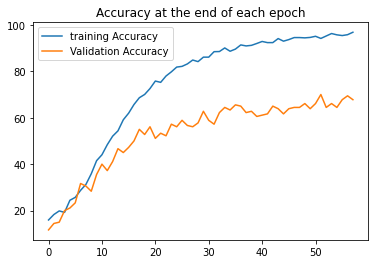

In [28]:
plt.plot(train_accuracy, label='training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();
plt.savefig(f"Accuracy_comparision_{optim}_lr_{learning_rate}_model_{mo}_no_COH.png")

### Standardize the Confusion Matrix and Display the Matrix ###

In [29]:
final_matrix = confusion_matrix / confusion_matrix.sum(axis = 0)
final_matrix

array([[0.72      , 0.08695652, 0.10526316, 0.23529412, 0.        ,
        0.        , 0.        ],
       [0.        , 0.60869565, 0.        , 0.08823529, 0.        ,
        0.03846154, 0.04      ],
       [0.12      , 0.04347826, 0.84210526, 0.08823529, 0.03571429,
        0.07692308, 0.08      ],
       [0.08      , 0.26086957, 0.        , 0.35294118, 0.        ,
        0.        , 0.16      ],
       [0.        , 0.        , 0.        , 0.        , 0.96428571,
        0.        , 0.        ],
       [0.04      , 0.        , 0.        , 0.17647059, 0.        ,
        0.76923077, 0.12      ],
       [0.04      , 0.        , 0.05263158, 0.05882353, 0.        ,
        0.11538462, 0.6       ]])

/tmp/ipykernel_1883/1896043099.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+target_cols)
/tmp/ipykernel_1883/1896043099.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+target_cols, rotation=90)


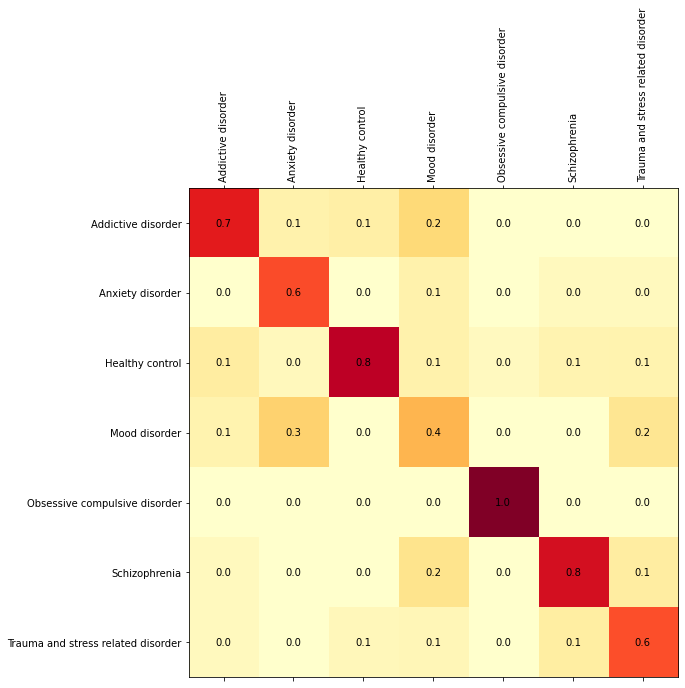

<Figure size 432x288 with 0 Axes>

In [30]:
## SHOW CONFUSION MATRIX

target_cols = Y.columns.tolist()
fig, ax = plt.subplots()
fig.set_figheight(9)
fig.set_figwidth(9)
ax.set_yticklabels(['']+target_cols)
ax.set_xticklabels(['']+target_cols, rotation=90)

# Using matshow here just because it sets the ticks up nicely. imshow is faster.
ax.matshow(final_matrix, cmap='YlOrRd')
for (i, j), z in np.ndenumerate(final_matrix):
    ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')
plt.show()
plt.savefig(f"Confusion_matrix_{optim}_lr_{learning_rate}_model_{mo}_no_COH.png")

## TESTING ON TEST DATA ##

In [36]:
ttestt = pd.read_csv("final_dataset_all_no_coh_test.csv")
ttestt.shape

(70, 115)

In [37]:
target = 'main.disorder'

test_y = ttestt[target].copy()
test_y.shape

(70,)

In [38]:
test_Y = pd.get_dummies(test_y)
test_Y.shape

(70, 7)

In [39]:
test_X = ttestt.drop([target], axis = 1)
test_X.shape

(70, 114)

In [40]:
datasets['ttestt'] = EEGDataset(test_X,test_Y)
print("Number of testing samples: ",len(datasets['ttestt']))
ttestt_loader = DataLoader(datasets['ttestt'],shuffle=True)

Number of testing samples:  70


In [ ]:
model = CNNmodel().to(device)
model.load_state_dict(torch.load('no_COH_epoch_47_model_Deep_ADAM.pth.tar'))

In [50]:
test_accuracy = []
test_confusion_matrix = np.zeros((7,7))
test_correct = 0
test_total = 0

CNNmodel.eval()
with torch.no_grad():
    for b, (X_test, y_test) in enumerate(ttestt_loader):
        y_test = y_test.to(device)
        X_test = X_test.to(device)
        yhat_test = CNNmodel(X_test)     
        _, predicted = torch.max(yhat_test.data, 1)
        test_total += y_test.size(0)  #keep track of total
        actual = torch.argmax(y_test,1)
        test_correct += (predicted == actual).sum().item()  #.item() give the raw number
        test_confusion_matrix[predicted][actual] +=1
        test_acc = 100 * (test_correct / test_total)
        # test_loss = criterion(yhat_test, y_test)
# test_losses.append(test_loss)
test_accuracy.append(test_acc)

In [53]:
print(f"Test_Dataset_Accuracy: {test_accuracy[0]}")

Test_Dataset_Accuracy: 15.714285714285714


In [54]:
test_final_matrix = test_confusion_matrix / test_confusion_matrix.sum(axis = 0)
test_final_matrix

array([[0.1, 0.2, 0.2, 0. , 0.1, 0.1, 0.3],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0.8, 0.6, 0.7, 0.7, 0.5, 0.6, 0.5],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0.1, 0.2, 0.1, 0.3, 0.3, 0.3, 0.2],
       [0. , 0. , 0. , 0. , 0.1, 0. , 0. ]])

/tmp/ipykernel_1883/2827707624.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+target_cols)
/tmp/ipykernel_1883/2827707624.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+target_cols, rotation=90)


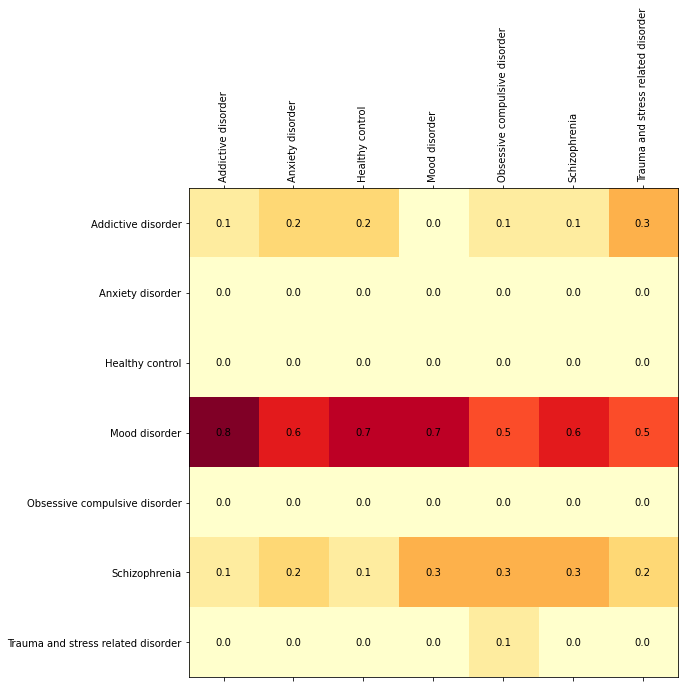

<Figure size 432x288 with 0 Axes>

In [55]:
## SHOW CONFUSION MATRIX

target_cols = Y.columns.tolist()
fig, ax = plt.subplots()
fig.set_figheight(9)
fig.set_figwidth(9)
ax.set_yticklabels(['']+target_cols)
ax.set_xticklabels(['']+target_cols, rotation=90)

# Using matshow here just because it sets the ticks up nicely. imshow is faster.
ax.matshow(test_final_matrix, cmap='YlOrRd')
for (i, j), z in np.ndenumerate(test_final_matrix):
    ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')
plt.show()
plt.savefig(f"Test_Confusion_matrix_{optim}_lr_{learning_rate}_model_{mo}.png")

## ACCURACY METRICS ##

$$Accuracy = \frac{TP+TN}{TP+TN+FP+FN}$$
$$Precision = \frac{TP}{TP+FP}$$
$$Recall = \frac{TP}{TP+FN}$$
$$F1 = \frac{2*Precision*Recall}{Precision+Recall} = \frac{2*TP}{2*TP+FP+FN}$$

In [5]:
diag_x = np.diag(test_final_matrix)
# print(diag_x)
precison = diag_x / test_final_matrix.sum(axis=0)
recall = diag_x / test_final_matrix.sum(axis=1)

/tmp/ipykernel_331/3789938909.py:4: RuntimeWarning: invalid value encountered in true_divide
  recall = diag_x / test_final_matrix.sum(axis=1)


In [6]:
F1 = 2*precison*recall/(precison+recall)
F1 = F1.tolist()
precison = precison.tolist()
recall = recall.tolist()

/tmp/ipykernel_331/680311890.py:1: RuntimeWarning: invalid value encountered in true_divide
  F1 = 2*precison*recall/(precison+recall)


In [12]:
metrics = pd.DataFrame([precison, recall,F1],columns=target_cols,index=['precison', 'recall','F1'])

In [13]:
metrics

,Addictive disorder,Anxiety disorder,Healthy control,Mood disorder,Obsessive compulsive disorder,Schizophrenia,Trauma and stress related disorder
precison,0.1,0.0,0.0,0.700000,0.0,0.30,0.0
recall,0.1,NaN,NaN,0.159091,NaN,0.20,0.0
F1,0.1,NaN,NaN,0.259259,NaN,0.24,NaN
